<a href="https://colab.research.google.com/github/hila-chefer/NLP_Final_Project/blob/main/Explainability_Based_Attention_Head_Analysis_for_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explainability-Based Attention Head Analysis for Transformers**

In [129]:
!git clone https://github.com/hila-chefer/NLP_Final_Project

import os
os.chdir(f'./NLP_Final_Project')

!pip install -r requirements.txt

Cloning into 'NLP_Final_Project'...
remote: Enumerating objects: 911, done.
remote: Counting objects: 100% (911/911), done.
remote: Compressing objects: 100% (642/642), done.
remote: Total 911 (delta 178), reused 904 (delta 176), pack-reused 0
Receiving objects: 100% (911/911), 1.68 MiB | 22.62 MiB/s, done.
Resolving deltas: 100% (178/178), done.


# **LXMERT**

**Examples from paper**

In [55]:
from lxmert.lxmert.src.modeling_frcnn import GeneralizedRCNN
import lxmert.lxmert.src.vqa_utils as utils
from lxmert.lxmert.src.processing_image import Preprocess
from transformers import LxmertTokenizer
from lxmert.lxmert.src.huggingface_lxmert import LxmertForQuestionAnswering
from lxmert.lxmert.src.lxmert_lrp import LxmertForQuestionAnswering as LxmertForQuestionAnsweringLRP
from lxmert.lxmert.src.VisualizationsGenerator import GeneratorOurs as VisGen
from lxmert.lxmert.src.ExplanationGenerator import HeadPrune, LayerPrune
import random
import torch
import cv2

In [38]:
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"

In [44]:
class ModelUsage:
    def __init__(self):
        self.vqa_answers = utils.get_data(VQA_URL)

        # load models and model components
        self.frcnn_cfg = utils.Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
        self.frcnn_cfg.MODEL.DEVICE = "cuda"

        self.frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=self.frcnn_cfg)

        self.image_preprocess = Preprocess(self.frcnn_cfg)

        self.lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

        self.lxmert_vqa = LxmertForQuestionAnsweringLRP.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")
        self.lxmert_vqa_no_lrp = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")

        self.lxmert_vqa.eval()
        self.lxmert_vqa_no_lrp.eval()
        self.model = self.lxmert_vqa

    def forward(self, item):
        URL, question = item
        
        self.image_file_path = URL

        # run frcnn
        images, sizes, scales_yx = self.image_preprocess(URL)
        output_dict = self.frcnn(
            images,
            sizes,
            scales_yx=scales_yx,
            padding="max_detections",
            max_detections= self.frcnn_cfg.max_detections,
            return_tensors="pt"
        )
        inputs = self.lxmert_tokenizer(
            question,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )
        self.question_tokens = self.lxmert_tokenizer.convert_ids_to_tokens(inputs.input_ids.flatten())
        self.text_len = len(self.question_tokens)
        # Very important that the boxes are normalized
        normalized_boxes = output_dict.get("normalized_boxes")
        features = output_dict.get("roi_features")
        self.image_boxes_len = features.shape[1]
        self.bboxes = output_dict.get("boxes")
        self.output = self.lxmert_vqa(
            input_ids=inputs.input_ids.to("cuda"),
            attention_mask=inputs.attention_mask.to("cuda"),
            visual_feats=features.to("cuda"),
            visual_pos=normalized_boxes.to("cuda"),
            token_type_ids=inputs.token_type_ids.to("cuda"),
            return_dict=True,
            output_attentions=False,
        )
        return self.output

    def forward_prune(self, item, text_prune, image_prune):
        URL, question = item
        
        self.image_file_path = URL

        # run frcnn
        images, sizes, scales_yx = self.image_preprocess(URL)
        output_dict = self.frcnn(
            images,
            sizes,
            scales_yx=scales_yx,
            padding="max_detections",
            max_detections= self.frcnn_cfg.max_detections,
            return_tensors="pt"
        )
        inputs = self.lxmert_tokenizer(
            question,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )
        # Very important that the boxes are normalized
        normalized_boxes = output_dict.get("normalized_boxes")
        features = output_dict.get("roi_features")
        output = self.lxmert_vqa_no_lrp(
            input_ids=inputs.input_ids.to("cuda"),
            attention_mask=inputs.attention_mask.to("cuda"),
            visual_feats=features.to("cuda"),
            visual_pos=normalized_boxes.to("cuda"),
            token_type_ids=inputs.token_type_ids.to("cuda"),
            return_dict=True,
            output_attentions=False,
            text_head_prune=text_prune,
            image_head_prune=image_prune,
        )

        answer = self.vqa_answers[output.question_answering_score.argmax()]
        return answer

In [88]:
def save_image_vis(image_file_path, bbox_scores, pert_step=0):
    img = cv2.imread(image_file_path)
    mask = torch.zeros(img.shape[0], img.shape[1])
    for index in range(len(bbox_scores)):
        [x, y, w, h] = model.bboxes[0][index]
        curr_score_tensor = mask[int(y):int(h), int(x):int(w)]
        new_score_tensor = torch.ones_like(curr_score_tensor)*bbox_scores[index].item()
        mask[int(y):int(h), int(x):int(w)] = torch.max(new_score_tensor,mask[int(y):int(h), int(x):int(w)])
    if mask.max() > 0:
      mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = mask.unsqueeze_(-1)
    mask = mask.expand(img.shape)
    img = img * mask.cpu().data.numpy()
    cv2.imwrite(
            'experiments/lxmert/result_pert_{0}.jpg'.format(pert_step), img)

In [52]:
model = ModelUsage()
vis_gen = VisGen(model)
head_prune = HeadPrune(model)

image_ids = [
    # giraffe
    'COCO_val2014_000000054123'
]

test_questions_for_images = [
    ################## paper samples
    # zebra
    "how many zebras are facing away from the camera?"
    ################## paper samples
]

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [69]:
pert_steps = [0, 0.4, 0.6, 0.9]

In [112]:
def generate_perturbation_visualizations(URL, text):
  scores_text, scores_image, _, _ = head_prune.generate_ours((URL, text))

  num_text_layers = len(scores_text)
  num_image_layers = len(scores_image)
  num_text_heads = scores_text[0].shape[0]
  num_image_heads = scores_image[0].shape[0]
  tot_num = num_text_layers * num_text_heads + num_image_layers * num_image_heads

  scores_text = torch.stack(scores_text)
  scores_image = torch.stack(scores_image)
  joint_scores = torch.cat([scores_text, scores_image]).to("cuda")
  all_text_scores = []

  for step_idx, step in enumerate(pert_steps):
      # find top step heads
      curr_num = int((1 - step) * tot_num)
      joint_scores = joint_scores.flatten()
      _, top_heads = joint_scores.topk(k=curr_num, dim=-1)
      heads_indicator = torch.zeros_like(joint_scores)
      heads_indicator[top_heads] = 1
      heads_indicator = heads_indicator.reshape(num_text_layers + num_image_layers, num_image_heads)
      heads_indicator_text = heads_indicator[:num_text_layers, :]
      heads_indicator_image = heads_indicator[num_text_layers:, :]
      R_t_t, R_t_i = vis_gen.generate_ours((URL, text), head_prune_text=heads_indicator_text, head_prune_image=heads_indicator_image)
      model.forward_prune((URL, text), heads_indicator_text, heads_indicator_image)
      image_scores = R_t_i[0]
      text_scores = R_t_t[0, 1:-1]
      save_image_vis(URL, image_scores, pert_step=step)
      all_text_scores.append(text_scores)   
  return model.question_tokens, all_text_scores

In [113]:
import matplotlib.pyplot as plt
from PIL import Image
from captum.attr import visualization
import requests

Text explainability after pruning 0% of the heads:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,how many zebra ##s are facing away from the camera ?


Text explainability after pruning 40.0% of the heads:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,how many zebra ##s are facing away from the camera ?


Text explainability after pruning 60.0% of the heads:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,how many zebra ##s are facing away from the camera ?


Text explainability after pruning 90.0% of the heads:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,how many zebra ##s are facing away from the camera ?


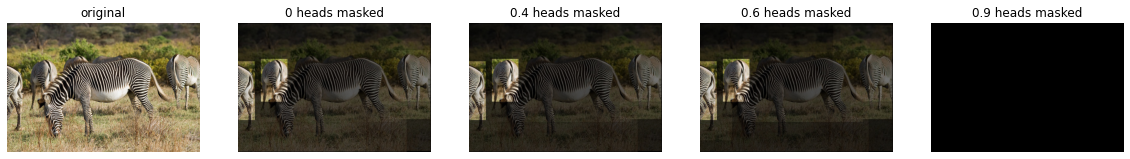

In [114]:
URL = 'experiments/lxmert/{0}_orig.jpg'.format(image_ids[0])
question, all_text_scores = generate_perturbation_visualizations(URL, test_questions_for_images[0])
orig_image = Image.open(model.image_file_path)

fig, axs = plt.subplots(ncols=5, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');
for step_idx, step in enumerate(pert_steps):
  masked_image = Image.open('experiments/lxmert/result_pert_{0}.jpg'.format(step))
  axs[step_idx+1].imshow(masked_image);
  axs[step_idx+1].axis('off');
  axs[step_idx+1].set_title('{0} heads masked'.format(step));
  text_scores = all_text_scores[step_idx]
  text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
  print("Text explainability after pruning {0}% of the heads:".format(step*100))
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model.question_tokens[1:-1],1)]
  visualization.visualize_text(vis_data_records)

# **Online Examples**

To upload your own example, simply modify the URL to your image url, and the question to your question.

Text explainability after pruning 0% of the heads:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,where is the knife ?


Text explainability after pruning 40.0% of the heads:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,where is the knife ?


Text explainability after pruning 60.0% of the heads:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,where is the knife ?


Text explainability after pruning 90.0% of the heads:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,where is the knife ?


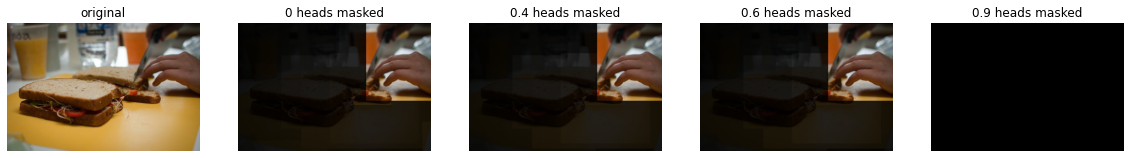

In [115]:
URL = "https://vqa.cloudcv.org/media/val2014/COCO_val2014_000000549112.jpg"
question =  'where is the knife?'

# save image to experiments folder
im = Image.open(requests.get(URL, stream=True).raw)
im.save('experiments/lxmert/online_image.jpg', 'JPEG')
URL = 'experiments/lxmert/online_image.jpg'

question, all_text_scores = generate_perturbation_visualizations(URL, question)

orig_image = Image.open(model.image_file_path)

fig, axs = plt.subplots(ncols=5, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');
for step_idx, step in enumerate(pert_steps):
  masked_image = Image.open('experiments/lxmert/result_pert_{0}.jpg'.format(step))
  axs[step_idx+1].imshow(masked_image);
  axs[step_idx+1].axis('off');
  axs[step_idx+1].set_title('{0} heads masked'.format(step));
  text_scores = all_text_scores[step_idx]
  text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
  print("Text explainability after pruning {0}% of the heads:".format(step*100))
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model.question_tokens[1:-1],1)]
  visualization.visualize_text(vis_data_records)

# **VisualBERT**

Since MMF does not support single image loading, we present the result images for each pruning step as saved by running the VisualBERT visualizations script. To run this script and get the results locally, see our README: https://github.com/hila-chefer/NLP_Final_Project#34generating-visualizations

QUESTION:  how tall is the grass?


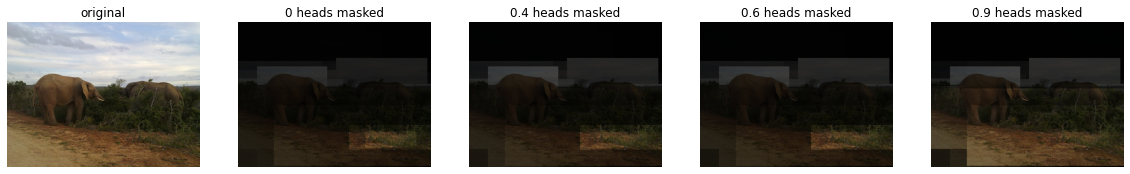

In [130]:
URL = 'experiments/visualBERT/COCO_val2014_000000097230_orig.jpg'
question =  'how tall is the grass?'

# save image to experiments folder
orig_image = Image.open(URL)

fig, axs = plt.subplots(ncols=5, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');
print("QUESTION: ", question)
for step_idx, step in enumerate(pert_steps):
  masked_image = Image.open('experiments/visualBERT/COCO_val2014_000000097230_{0}.jpg'.format(step*100))
  axs[step_idx+1].imshow(masked_image);
  axs[step_idx+1].axis('off');
  axs[step_idx+1].set_title('{0} heads masked'.format(step));